In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os
import pandas as pd
import numpy as np
import base64
import json
from io import BytesIO
from IPython.display import Image, display


from dto import *
from metrics import *

%matplotlib inline

### Parsing JSON file with measurements

In [12]:
filename = 'measurements.json'
poses_json_path = os.path.join('../', '../', 'data', filename)
f = open(poses_json_path, 'r')

measurements_data = json.load(f)

print("Keys in {} file: {}".format(filename, measurements_data.keys()))
print("Elements in 'measurements' array count: %i" % len(measurements_data['measurements']))

Keys in measurements.json file: dict_keys(['measurements'])
Elements in 'measurements' array count: 25


In [24]:
measurements_dicts_list = measurements_data['measurements']
measurements = [Measurement.init_from_dict(d) for d in measurements_dicts_list]

measurements_count = len(measurements)
print("Measurements count: %i" % measurements_count)

Measurements count: 25


### Base function for executing metrics on measurements

In [25]:
def can_execute(metric: Metric, measurement: Measurement) -> bool:
    """Checks if measurement has all required joints"""
    
    required_joints = metric.required_joints
    received_joints = measurement.joints.keys()
    hits_bitmap = [required_joint in received_joints for required_joint in required_joints]
    return hits_bitmap.count(False) == 0


def execute_metrics(metrics: list, measurement: Measurement) -> list:
    """
    Executes multiple metrics on passed measurement
    
    :return: list, len is n_metrics
    """

    return [m.compute(measurement) if can_execute(m, measurement) else None for m in metrics]


def execute_measurements(metrics: list, measurements: list) -> np.ndarray:
    """
    Executes multiple metrics on multiple measurements
    
    :return: np.array, shape is (n_measurements, n_metrics)
    """
    results = np.array([execute_metrics(metrics, m) for m in measurements])
    return results


def execute(metrics: list, measurements: list) -> pd.DataFrame:
    """
    High level function. Executes metrics on measurements 
    and creates pandas Dataframe describing the results
    """
    
    results = execute_measurements(metrics, measurements)
    
    # Base data with identifier and label columns
    data = {
        'uuid': [m.uuid for m in measurements],
        'Is good': [m.is_good for m in measurements]
    }
    
    # Adding columns of multiple metrics results
    for metric, results_column in zip(metrics, results.T):        
        key = type(metric).display_name()
        value = [result.display_result() for result in results_column]
        data[key] = value
        
    df = pd.DataFrame(data)
    return df

In [26]:
metrics = [
    HeadBodyProportionMetric()
]

df = execute(metrics, measurements)
df

uuid  Is good  Head Body Proportion
0   55BC916E-BE82-4C01-BC31-B253599D4A8D     True              2.250000
1   A1E66C99-085D-419B-BDF5-2FD869C7F2B3     True              2.000000
2   EB57C2C2-21F7-4677-B812-3E159F6AE90B     True              2.000000
3   14EB9E50-AA96-44D9-B725-17D21B86162F     True              2.000000
4   8532812F-5A9C-43F7-A8FE-B5722E5250B9     True              1.666667
5   F86EBA45-7114-42A7-8796-ADEEAC99186E     True              2.000000
6   9EF085D1-6917-4DBA-81B4-66411C62A1BD     True              3.000000
7   2FC481BF-24DD-4733-9B4C-6FE695B7C0EF     True              2.000000
8   114FF101-AB3E-4C60-BEC7-1C2D0A883CF6     True              2.000000
9   48A99CDC-BA00-4901-9805-DBF37C1867D4     True              2.000000
10  DCD4D28B-D1C0-42A1-9C4A-7CE2A2F99F19     True              2.500000
11  B86B15B3-CE0B-4709-A9FD-503172632394     True              3.500000
12  2F051ADE-F8DB-4AD0-BDC1-529AFCF48E74     True              3.500000
13  E6323214-6D62-4297-BA25-DBD637C78ED1     True              2.250000
14  70149D20-2CD9-4147-9BA3-8BA89CE93ACF     True              2.333333
15  18A25B26-063B-48AF-8DED-40819B0AF751     True              2.500000
16  A68A5D6A-2834-4661-BF19-0BA47AC757CB     True              2.500000
17  93526B8C-CD18-411D-B5E2-46CA7C956110     True              2.000000
18  8942BF9F-FEE1-4DBD-AA82-72C0CCDA23DB     True              2.666667
19  95C00E56-8C1E-4BD6-B926-FA02B0603552     True              4.000000
20  0827C4F3-7146-4EEC-864F-371B3EBA84A6    False              2.666667
21  5C1648EF-2142-427E-A11E-1B5E0F26CB87    False              2.000000
22  B81F4A4A-F2F6-463E-AD85-BFDB0FCB18FE    False              1.666667
23  B641D734-D38D-4690-917F-FAB5EC554B08    False              2.666667
24  1B285A41-1AC3-4D44-9446-19461BEDC566    False              2.000000

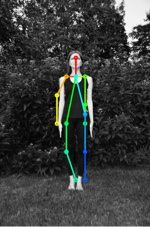

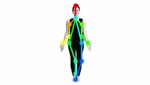

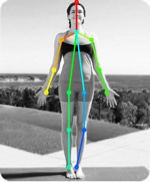

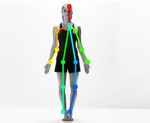

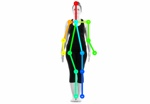

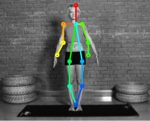

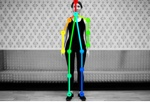

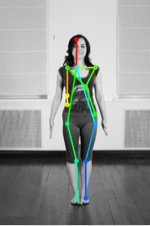

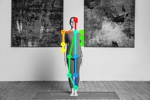

In [22]:
def extract_image(measurement: Measurement, image_format: str = 'jpeg') -> Image:
    """
    Extracts base64 encoded image from measurement and creates IPython.display.Image
    """
    
    image_preview_b64str = measurement.image_preview
    image_data = base64.decodebytes(base64.b64decode(image_preview_b64str))
    image_data_wrapper = BytesIO(image_data)
    image = Image(image_data_wrapper.getvalue(), format=image_format)
    return image

for measurement in measurements:
    image = extract_image(measurement)
    display(image)